# Basic example
This notebook demonstrates using `axtreme` to solve a toy problem.


The following creates a toy problem, and calculates the brute force solution. We then demonstrate how `axtreme` can be used to achieve the same results while running the simulator far fewer times. Specially, we show how to:
- Define the problem in the Ax framework.
- Create a surrogate model (automatically using ax).
- Estimate the QoI.
- Use DoE to reduce uncertainty.


> NOTE: This is an introductory example intended to provide an overview of the process. As such, a number of simplification are made. More in depth tutorial are provided here at a later date.

In [1]:
import sys
from collections.abc import Callable
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from ax import (
    Experiment,
    SearchSpace,
)
from ax.core import GeneratorRun, ObservationFeatures, ParameterType, RangeParameter
from ax.modelbridge.registry import Models
from botorch.optim import optimize_acqf
from matplotlib.axes import Axes
from numpy.typing import NDArray
from plotly.subplots import make_subplots
from scipy.stats import gumbel_r
from torch.distributions import Normal
from torch.utils.data import DataLoader

from axtreme import sampling
from axtreme.acquisition import QoILookAhead
from axtreme.data import FixedRandomSampler, MinimalDataset
from axtreme.experiment import add_sobol_points_to_experiment, make_experiment
from axtreme.plotting.gp_fit import plot_gp_fits_2d_surface, plot_surface_over_2d_search_space
from axtreme.plotting.histogram3d import histogram_surface3d
from axtreme.qoi import MarginalCDFExtrapolation
from axtreme.qoi.qoi_estimator import QoIEstimator
from axtreme.sampling.ut_sampler import UTSampler
from axtreme.simulator import utils as sim_utils
from axtreme.utils import population_estimators, transforms

torch.set_default_dtype(torch.float64)
device = "cpu"

# pyright: reportUnnecessaryTypeIgnoreComment=false

## Explore the toy problem
The `axtreme` package expects 2 key pieces of input:
- A simulator:
- Samples from the environment

Here we use a mock simulator and env data defined in `examples`. The following section explores these raw inputs.

In [2]:
root_dir = Path("../")
sys.path.append(str(root_dir))
from examples.demo2d.problem.env_data import collect_data
from examples.demo2d.problem.simulator import (
    DummySimulatorSeeded,
    _true_loc_func,
    _true_scale_func,
    dummy_simulator_function,
)

### Simulator
The toy simulator in this example uses a gumbel distribution as its noise model. A gumbel distribution has 2 parameters,
location (loc) and scale. The toy problem has one underlying function that controls the loc, and another to control the
scale. This can be written as:
- $y = loc(x) + noise, where noise ~ Gumbel(0, scale(x))$
- OR
- $y = Gumbel(loc(x), scale(x)).sample()$

In a real problem the underlying function that controls the output distribution would be unknown, but in this toy example
we plot them directly to give a better understanding of the problem being solved in this example.

In [3]:
# plot it
fig = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "surface"}]],
    subplot_titles=("location", "scale", "Gumbel response surface (at q = [.1, .5, .9])"),
)


plot_search_space = SearchSpace(
    parameters=[
        RangeParameter(name="x1", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
    ]
)

# plot the underling location and scale function
_ = fig.add_trace(plot_surface_over_2d_search_space(plot_search_space, funcs=[_true_loc_func]).data[0], row=1, col=1)
_ = fig.add_trace(plot_surface_over_2d_search_space(plot_search_space, funcs=[_true_scale_func]).data[0], row=1, col=2)


# Plot the response surface at different quantiles
def gumbel_helper(x: np.ndarray[tuple[int, int], np.dtype[np.float64]], q: float = 0.5) -> NDArray[np.float64]:
    return gumbel_r.ppf(q=q, loc=_true_loc_func(x), scale=_true_scale_func(x))


quantile_plotters: list[Callable[[np.ndarray[Any, np.dtype[np.float64]]], np.ndarray[Any, np.dtype[np.float64]]]] = [
    partial(gumbel_helper, q=q) for q in [0.1, 0.5, 0.9]
]
response_distribution = plot_surface_over_2d_search_space(plot_search_space, funcs=quantile_plotters)
_ = [fig.add_trace(data, row=1, col=3) for data in response_distribution.data]

# label the plot
_ = fig.update_scenes({"xaxis": {"title": "x1"}, "yaxis": {"title": "x2"}, "zaxis": {"title": "response"}})
_ = fig.update_traces(showscale=False)
fig.show()

### Environment 
The other input required by the `axtreme` package is static dataset of environment samples. Here we load and plot the data we will be using in this example.

In [4]:
import pandas as pd

raw_data: pd.DataFrame = collect_data()
display(raw_data.head(3))  # type: ignore

# we convert this data to Numpy for ease of use from here on out
env_data: NDArray[np.float64] = raw_data.to_numpy()
fig = histogram_surface3d(env_data)
_ = fig.update_layout(title_text="Environment distribution estimate from samples")
_ = fig.update_layout(scene_aspectmode="cube")
fig.show()

x1        x2
0  0.489545  0.409118
1  0.770289  0.047746
2  0.539691  0.248714

### Define the problem
Because we are using a toy example we can directly calculate the ERD and our QOI. This is the answer that we are trying to recover using the `axtreme` package (in which we make minimal use of the simulator).

We define the time span over which we wish to calculate the Extreme Response, and produce a brute force estimate.

Brute force estimate of our QOI is 33.79034770209607


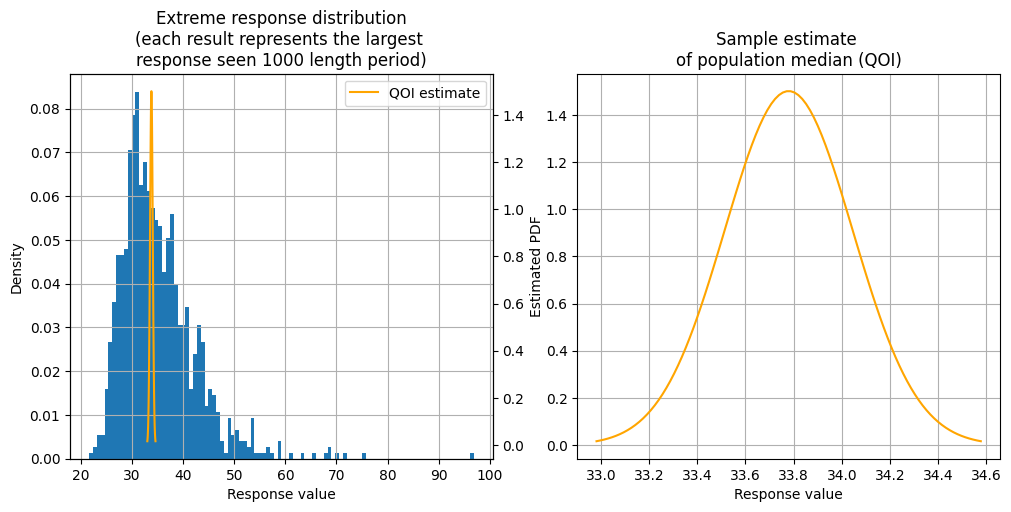

In [5]:
# define the time span
N_ENV_SAMPLES_PER_PERIOD = 1000


n_erd_samples = 1000
erd_samples = []
for _ in range(n_erd_samples):
    indices = np.random.choice(env_data.shape[0], size=N_ENV_SAMPLES_PER_PERIOD, replace=True)  # noqa: NPY002
    period_sample = env_data[indices]

    responses = dummy_simulator_function(period_sample)
    erd_samples.append(responses.max())

_, axes = plt.subplots(ncols=2, figsize=(12, 5))

# plot the ERD distribution
_ = axes[0].hist(erd_samples, bins=100, density=True)
population_median_est_dist = population_estimators.sample_median_se(torch.tensor(erd_samples))
_ = ax_twin = axes[0].twinx()
_ = population_estimators.plot_dist(population_median_est_dist, ax=ax_twin, c="orange", label="QOI estimate")
_ = ax_twin.set_ylabel("Estimated PDF")
_ = ax_twin.legend()
_ = axes[0].set_title(
    f"Extreme response distribution\n"
    f"(each result represents the largest \nresponse seen {N_ENV_SAMPLES_PER_PERIOD} length period)"
)
_ = axes[0].set_xlabel("Response value")
_ = axes[0].set_ylabel("Density")
_ = axes[0].grid(visible=True)

# Plot the estimated QoI distribution
_ = population_estimators.plot_dist(population_median_est_dist, ax=axes[1], c="orange")
_ = axes[1].set_title("Sample estimate \nof population median (QOI)")
_ = axes[1].set_xlabel("Response value")
_ = axes[1].grid(visible=True)


brute_force_qoi_estimate = np.median(erd_samples)
print(f"Brute force estimate of our QOI is {brute_force_qoi_estimate}")

# Using `axtreme` to solve the problem
In the section above we have explored the key inputs to the `axtreme` package (Simulator and Environment data), and calculated the brute force answer to our QoI. In this section we will show how `axtreme` can be used to achieve the same result, while running the simulator far fewer times.

`axtreme` is comprised of 4 main step:
- Define the problem in the Ax framework:
- Create a surrogate model: (this happens automatically once the problem has been defined in Ax).
- Estimate the Qoi: Estimate the QoI (and our confidence) using the surrogate model.
- DoE: reduce uncertainty in the QoI while running the simulator as little as possible.


## Define the problem in the `ax` framework.
The following steps need to be taken to define the problem in the Ax framework:
- Ensure the simulator conforms to the required interface.
- Decide on the search space to use.
- Pick a distribution that you believe captures the noise behaviour of your simulator.

These decisions are straight forward for this toy example. Advice on how to choose these parameters in more real world problems are provided in other tutorials (TODO(sw 2024-11-21): include these tutorials).


### Make our simulator conform to the required interface

In [6]:
# Check if it complies
print(sim_utils.is_valid_simulator(dummy_simulator_function, verbose=True))
# use a helper to add the 'n_simulations_per_point' functionality
sim = sim_utils.simulator_from_func(dummy_simulator_function)
# check that it now complies
print(sim_utils.is_valid_simulator(sim, verbose=True))

# NOTE: for the rest of this notebook we proceed with a seeded simulator. This is exactly the same as
# dummy_simulator_function except it makes our results reproducible.
sim = DummySimulatorSeeded()
print(sim_utils.is_valid_simulator(sim, verbose=True))

Parameter x has incorrect type.
False
True
True


### Pick the search space over which to create a surrogate

In [7]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name="x1", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
    ]
)

### Pick a distibution that you belive captures the noise behaviour of your simulator

In [8]:
dist = gumbel_r

## Automatically set up you experiment
Use the sim, search_space, and dist defined above to set up the `ax` `Experiment`.

In [9]:
def make_exp() -> Experiment:
    """Helper to ensure we always create an experiment with the same settings (so results are comparable)."""
    return make_experiment(sim, search_space, dist, n_simulations_per_point=200)


exp = make_exp()

## Create a Surrogate model:

Once we have defined an Ax experiment, we can use `ax` to create a surrogate. This surrogate provides the location and scale parameters for our gumbel distribution.

We first need to add some training data to the experiment. We do this by passing the experiment some initial x points. Behind the scenes, `ax` will run the Simulator to obtain estimates for the location and scale parameters at those points. It will then use that data to create a surrogate model.

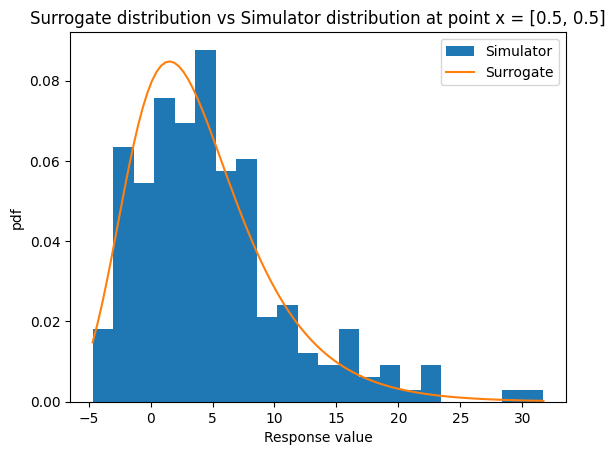

In [10]:
# Add random x points to the experiment
add_sobol_points_to_experiment(exp, n_iter=30, seed=8)

# Use ax to generate a surrogate
botorch_model_bridge = Models.BOTORCH_MODULAR(
    experiment=exp,
    data=exp.fetch_data(),
)

pred_mean, pred_covariance = botorch_model_bridge.predict([ObservationFeatures(parameters={"x1": 0.5, "x2": 0.5})])

# Lets compare the output distribution of the surrogate and the simulator at this point
pred_dist = dist(loc=pred_mean["loc"], scale=pred_mean["scale"])
simulator_samples = sim(np.array([[0.5, 0.5]]), n_simulations_per_point=200).flatten()


x_points = np.linspace(simulator_samples.min(), simulator_samples.max(), 100)

_ = plt.hist(simulator_samples, bins=len(simulator_samples) // 9, density=True, label="Simulator")
_ = plt.plot(x_points, pred_dist.pdf(x_points), label="Surrogate")  # type: ignore
_ = plt.xlabel("Response value")
_ = plt.ylabel("pdf")
_ = plt.title("Surrogate distribution vs Simulator distribution at point x = [0.5, 0.5]")
_ = plt.legend()
plt.show()

The surrogate also contains uncertainty about its estimate. Lets plot the other distributions that the surrogate believes are possible.

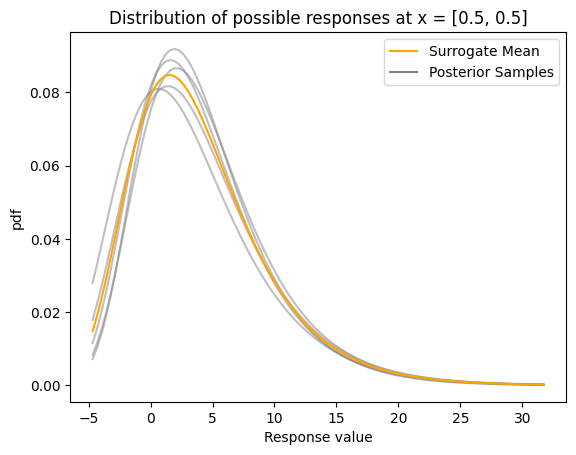

In [11]:
mean = np.array([pred_mean["loc"], pred_mean["scale"]])
mean = mean.flatten()

covariance = np.array(
    [
        [pred_covariance["loc"]["loc"], pred_covariance["loc"]["scale"]],
        [pred_covariance["scale"]["loc"], pred_covariance["scale"]["scale"]],
    ]
)
covariance = covariance.reshape(2, 2)

surrogate_distribution = scipy.stats.multivariate_normal(mean, covariance)
surrogate_distribution_samples = surrogate_distribution.rvs(size=5, random_state=6)
for sample in surrogate_distribution_samples:
    sample_dist = dist(loc=sample[0], scale=sample[1])
    _ = plt.plot(x_points, sample_dist.pdf(x_points), c="grey", alpha=0.5)  # type: ignore

_ = plt.plot(x_points, pred_dist.pdf(x_points), c="orange", label="Surrogate Mean")  # type: ignore
_ = plt.plot([], [], label="Posterior Samples", c="grey")  # hacky way to add a label
_ = plt.title("Distribution of possible responses at x = [0.5, 0.5]")
_ = plt.xlabel("Response value")
_ = plt.ylabel("pdf")
_ = plt.legend()
plt.show()

## Estimate the QoI:
Now that we have a surrogate model, we can use it to estimate the QoI. The uncertainty in our surrogate model should be reflected in our QoI estimate. Lets demonstrate how the estimate changes as we add more data to the surrogate model and it becomes more certain.

In the following we make use of an existing QoI Estimator. `axtreme` provides a number of QoIEstimators for common tasks, but users can also create custom QoIEstimator for their specific problems. Details can be found (TODO(sw 2024-11-22): link to tutorial on how to create a custom QoIEstimator).

In the following we demonstrate how the QoI estimate becomes more certain as the surrogate gets more training data.

> NOTE: Training a Gp with `Models.BOTORCH_MODULAR` has inherit randomness that can't be turned off (e.g with `torch.manual_seed`). As a result there is slight randomness in the result even though all other seeds are set.

In [12]:
# A note on DataLoaders:
# We make use of Dataloader to manage providing data to the QoI. Env samples are only used in the QoI, so your env data
# can be in whatever format is supported by the QoI.
n_env_samples = 1_000
dataset = MinimalDataset(env_data)
sampler = FixedRandomSampler(dataset, num_samples=n_env_samples, seed=10, replacement=True)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=256)

posterior_sampler = UTSampler()
# posterior_sampler = NormalIndependentSampler(torch.Size([n_posterior_samples])

qoi_estimator = MarginalCDFExtrapolation(
    # random dataloader give different env samples for each instance
    env_iterable=dataloader,
    period_len=N_ENV_SAMPLES_PER_PERIOD,
    quantile=torch.tensor(0.5),
    quantile_accuracy=torch.tensor(0.01),
    # IndexSampler needs to be used with GenericDeterministicModel. Each sample just selects the mean.
    posterior_sampler=posterior_sampler,
)

In [13]:
# Initialise and environment, get gp from `ax`, and calculate the QOI

n_training_points = [30, 50, 128, 512]
results = []

for points in n_training_points:
    exp = make_exp()
    add_sobol_points_to_experiment(exp, n_iter=points, seed=8)
    # Use ax to create a gp from the experiment
    botorch_model_bridge = Models.BOTORCH_MODULAR(
        experiment=exp,
        data=exp.fetch_data(),
    )

    # We need to collect the transforms used to the model gives result in the problem/outcome space.
    input_transform, outcome_transform = transforms.ax_to_botorch_transform_input_output(
        transforms=list(botorch_model_bridge.transforms.values()), outcome_names=botorch_model_bridge.outcomes
    )
    qoi_estimator.input_transform = input_transform
    qoi_estimator.outcome_transform = outcome_transform

    model = botorch_model_bridge.model.surrogate.model
    # reseed the dataloader each time so the dame dataset is used.
    results.append(qoi_estimator(model))

In [14]:
def get_mean_var(estimator: QoIEstimator, estimates: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """TODO: clean this up or delete.

    Args:
        estimator: the QoI function that produced the estimate
        estimates: (*b, n_estimator)

    Returns:
        tensor1: the mean of the estimates, with shape *b
        tensor1: the mean of the estimates, with shape *b

    """
    if not isinstance(estimates, torch.Tensor):  # pyright: ignore[reportUnnecessaryIsInstance]
        estimates = torch.tensor(estimates)

    mean = estimator.posterior_sampler.mean(estimates, -1)  # pyright: ignore[reportAttributeAccessIssue]
    var = estimator.posterior_sampler.var(estimates, -1)  # pyright: ignore[reportAttributeAccessIssue]

    return mean, var

C:\Users\SEBWIN\AppData\Local\Temp\ipykernel_36644\3544660317.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



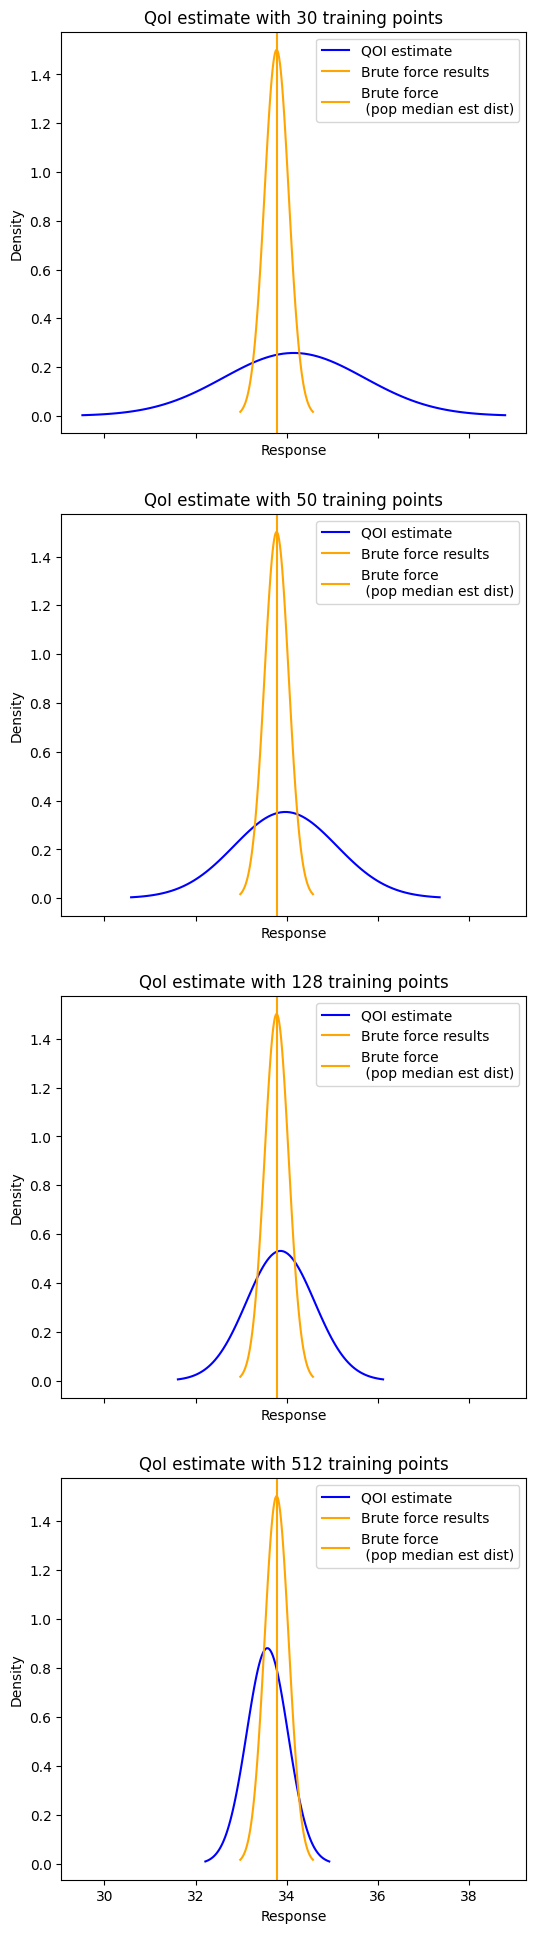

In [15]:
_, axes = plt.subplots(nrows=len(n_training_points), sharex=True, figsize=(6, 6 * len(n_training_points)))

for ax, estimate, n_points in zip(axes, results, n_training_points, strict=True):
    mean, var = get_mean_var(qoi_estimator, torch.tensor(estimate))
    qoi_dist = Normal(mean, var**0.5)
    _ = population_estimators.plot_dist(qoi_dist, ax=ax, c="blue", label="QOI estimate")

    ax.axvline(brute_force_qoi_estimate, c="orange", label="Brute force results")
    _ = population_estimators.plot_dist(
        population_median_est_dist, ax=ax, c="orange", label="Brute force\n (pop median est dist)"
    )
    ax.set_title(f"QoI estimate with {n_points} training points")
    ax.set_xlabel("Response")
    ax.set_ylabel("Density")
    ax.legend()

# Note: if you are interested, the following allows you to see the result of the QoIEstimator if uncertainty is ignored.
# this may not be a very good estimate if the simulator mean doesn't match the surrogate.
# from axtreme.eval.qoi import qoi_ignoring_gp_uncertainty  # noqa: ERA001
# result_no_gp_uncertainty = qoi_ignoring_gp_uncertainty(qoi_estimator_gp_brute_force, model)  # noqa: ERA001

## DoE: efficiently reduce uncertainty in the QoI.

In the plots above we see QoI uncertainty can be reduced by adding training data. In this section we explore if we can
obtain a similar reduction in uncertainty with fewer training point. We do this by picking new points intelligently.

First we perform DoE using a space filling design (Sobol). This is the baseline that DoE should be able to improve on.
We then run DoE using our custom acquisition function (QoILookAhead), and compare results.

### Helper for runnig experiments

In [16]:
def run_trials(
    experiment: Experiment,
    warm_up_generator: Callable[[Experiment], GeneratorRun],
    doe_generator: Callable[[Experiment], GeneratorRun],
    qoi_estimator: MarginalCDFExtrapolation,
    warm_up_runs: int = 3,
    doe_runs: int = 15,
    qoi_iter: int = 1,
) -> NDArray[np.float64]:
    """Helper function for running many trials for an experiment and returning the QOI results.

    Args:
        experiment: Experiment to perform DOE on.
        warm_up_generator: Generator to create the initial training data on the experiment (e.g., Sobol).
        doe_generator: The generator being used to perform the DoE.
        qoi_estimator: The function to estimate the QOI after new data points are added to the experiment.
        warm_up_runs: Number of warm-up runs to perform before starting the DoE.
        doe_runs: Number of DoE runs to perform.
        qoi_iter: How often to calculate the QOI. If set to 1, the QOI will be calculated after every run.

    Returns:
        np.ndarray: Array of shape (n_qoi_iter, qoi_estimator_output) where:
            - n_qoi_iter: The number of times the qoi_estimator was called (on a new amount of data).
            - qoi_estimator_output: The results given on that dataset.
    """
    figs = []
    qoi_results = []
    for i in range(doe_runs + 1):
        if i == 0:
            for _ in range(warm_up_runs):
                generator_run = warm_up_generator(experiment)
                trial = experiment.new_trial(generator_run)
                _ = trial.run()
                _ = trial.mark_completed()

        else:
            generator_run = doe_generator(experiment)
            trial = experiment.new_trial(generator_run=generator_run)
            _ = trial.run()
            _ = trial.mark_completed()

        model_bridge = Models.BOTORCH_MODULAR(
            experiment=experiment,
            data=experiment.fetch_data(),
        )
        if i % qoi_iter == 0:
            input_transform, outcome_transform = transforms.ax_to_botorch_transform_input_output(
                transforms=list(model_bridge.transforms.values()), outcome_names=model_bridge.outcomes
            )

            qoi_estimator.input_transform = input_transform
            qoi_estimator.outcome_transform = outcome_transform

            qoi_samples = qoi_estimator(model=model_bridge.model.surrogate.model)
            qoi_results.append(qoi_samples.detach().numpy())
        if i in (0, doe_runs):
            figs.append(
                plot_gp_fits_2d_surface(model_bridge, search_space, {"loc": _true_loc_func, "scale": _true_scale_func})
            )
        print(f"iter {i} done")

    for fig in figs:
        fig.show()
    return np.vstack(qoi_results)

How many iterations to run in the following DOEs

In [17]:
n_iter = 40
qoi_iter = 1
warm_up_runs = 3

### Sobol model
Surrogate trained without and a acquisition function as a comparative baseline.

In [18]:
exp_sobol = make_exp()
# This needs to be instantiated outside of the loop so the internal state of the generator persists.
sobol = Models.SOBOL(search_space=exp_sobol.search_space, seed=5)


def sobol_generator_run(_: Experiment) -> GeneratorRun:  # pyright: ignore[reportRedeclaration]
    return sobol.gen(1)


qoi_results_sobol = run_trials(
    experiment=exp_sobol,
    warm_up_generator=sobol_generator_run,
    doe_generator=sobol_generator_run,
    qoi_estimator=qoi_estimator,
    warm_up_runs=warm_up_runs,
    doe_runs=n_iter,
    qoi_iter=qoi_iter,
)

iter 0 done
iter 1 done
iter 2 done
iter 3 done
iter 4 done
iter 5 done
iter 6 done
iter 7 done
iter 8 done
iter 9 done
iter 10 done
iter 11 done
iter 12 done
iter 13 done
iter 14 done
iter 15 done
iter 16 done
iter 17 done
iter 18 done
iter 19 done
iter 20 done
iter 21 done
iter 22 done
iter 23 done
iter 24 done
iter 25 done
iter 26 done
iter 27 done
iter 28 done
iter 29 done
iter 30 done
iter 31 done
iter 32 done
iter 33 done
iter 34 done
iter 35 done
iter 36 done
iter 37 done
iter 38 done
iter 39 done
iter 40 done


### Custom acquisition function:
We now set up the components required for the Custom acquisition function.

~~~
NOTE: It is important to understand the behaviour of the acquisition function, as this has implication for the
optimisation arguments used. The parameters set here are a robust option that do not assume a smooth function.
If you can guarantee the acquisition function is smooth this should be updated to use more efficient methods.
~~~

#### Optional: Explore optimisation settings

Prior to doing multiple rounds of optimisation, it can be useful to check the optimisation setting are appropriate
for the acquisition function. Here we perform and plot a grid search, and compare it to the optimisation value to get a
sense of the surface. This is more challenging to do in real problems


In [19]:
# Define the model to use.
exp = make_exp()
add_sobol_points_to_experiment(exp, n_iter=64, seed=8)

# Use ax to create a gp from the experiment
botorch_model_bridge = Models.BOTORCH_MODULAR(
    experiment=exp,
    data=exp.fetch_data(),
)

# We need to collect the transforms used to the model gives result in the problem/outcome space.
input_transform, outcome_transform = transforms.ax_to_botorch_transform_input_output(
    transforms=list(botorch_model_bridge.transforms.values()), outcome_names=botorch_model_bridge.outcomes
)
qoi_estimator.input_transform = input_transform
qoi_estimator.outcome_transform = outcome_transform

model = botorch_model_bridge.model.surrogate.model

# %% How long does a single run take
acqusition = QoILookAhead(model, qoi_estimator)
scores = acqusition(torch.tensor([[[0.5, 0.5]]]))

# %% Perform the grid search and plot
point_per_dim = 21
x1 = torch.linspace(0, 1, point_per_dim)
x2 = torch.linspace(0, 1, point_per_dim)
grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="xy")
grid = torch.stack([grid_x1, grid_x2], dim=-1)
# make turn into a shape that can be processsed by the acquisition function
x_candidates = grid.reshape(-1, 1, 2)
acqusition = QoILookAhead(model, qoi_estimator)
scores = acqusition(x_candidates)
scores = scores.reshape(grid.shape[:-1])

max_score  tensor(-0.9320)


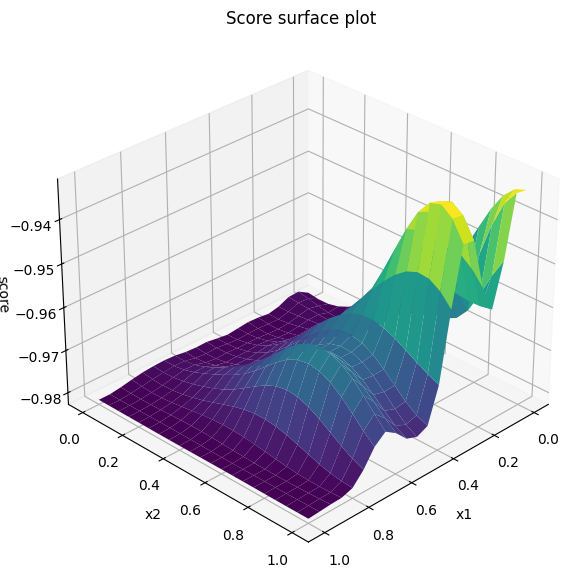

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
_ = ax.view_init(elev=30, azim=45)  # pyright: ignore[reportAttributeAccessIssue]
_ = ax.plot_surface(grid_x1, grid_x2, scores, cmap="viridis", edgecolor="none")  # pyright: ignore[reportAttributeAccessIssue]
_ = ax.set_xlabel("x1")
_ = ax.set_ylabel("x2")
_ = ax.set_zlabel("score")  # pyright: ignore[reportAttributeAccessIssue]
_ = ax.set_title("Score surface plot")
print("max_score ", scores.max())

In [21]:
# %% perform a round of optimisation using the under the hood optimiser
candidate, result = optimize_acqf(
    acqusition,
    bounds=torch.tensor([[0.0, 0.0], [1.0, 1.0]]),
    q=1,
    num_restarts=20,
    raw_samples=50,
    options={
        "with_grad": False,  # True by default.
        "method": "Nelder-Mead",  # "L-BFGS-B" by default
        "maxfev": 5,
    },
    retry_on_optimization_warning=False,
)
print(candidate, result)

tensor([[0.2781, 0.8122]]) tensor(-0.9336)


#### Lookahead acquisition function
Define the helpers to run the custom acquisition function.

In [22]:
acqf_class = QoILookAhead
posterior_sampler = sampling.MeanSampler()


def look_ahead_generator_run(experiment: Experiment) -> GeneratorRun:
    # Fist building model to get the transforms
    # TODO (se -2024-11-20): This refits hyperparameter each time, we don't want to do this.
    model_bridge_only_model = Models.BOTORCH_MODULAR(
        experiment=experiment,
        data=experiment.fetch_data(),
    )
    input_transform, outcome_transform = transforms.ax_to_botorch_transform_input_output(
        transforms=list(model_bridge_only_model.transforms.values()), outcome_names=model_bridge_only_model.outcomes
    )
    # Adding the transforms to the QoI estimator
    qoi_estimator.input_transform = input_transform
    qoi_estimator.outcome_transform = outcome_transform

    # Building the model with the QoILookAhead acquisition function
    model_bridge_cust_ac = Models.BOTORCH_MODULAR(
        experiment=experiment,
        data=experiment.fetch_data(),
        botorch_acqf_class=acqf_class,
        acquisition_options={
            "qoi_estimator": qoi_estimator,
            "sampler": posterior_sampler,
        },
    )

    # Optimizing the acquisition function to get the next point
    return model_bridge_cust_ac.gen(
        1,
        # Note these arg are supplied by default for this method.
        model_gen_options={
            "optimizer_kwargs": {
                "num_restarts": 20,
                "raw_samples": 50,
                "options": {
                    "with_grad": False,
                    "method": "Nelder-Mead",
                    "maxfev": 5,
                },
                "retry_on_optimization_warning": False,
            }
        },
    )

Run the DOE

In [23]:
exp_look_ahead = make_exp()
# This needs to be instantiated outside of the loop so the internal state of the generator persists.
sobol = Models.SOBOL(search_space=exp_look_ahead.search_space, seed=5)


def sobol_generator_run(_: Experiment) -> GeneratorRun:  # pyright: ignore[reportRedeclaration]
    return sobol.gen(1)


qoi_results_look_ahead = run_trials(
    experiment=exp_look_ahead,
    warm_up_generator=sobol_generator_run,
    doe_generator=look_ahead_generator_run,
    qoi_estimator=qoi_estimator,
    warm_up_runs=warm_up_runs,
    doe_runs=n_iter,
    qoi_iter=qoi_iter,
)

iter 0 done
iter 1 done
iter 2 done
iter 3 done
iter 4 done
iter 5 done
iter 6 done
iter 7 done
iter 8 done
iter 9 done
iter 10 done
iter 11 done
iter 12 done
iter 13 done
iter 14 done
iter 15 done
iter 16 done
iter 17 done
iter 18 done
iter 19 done
iter 20 done
iter 21 done
iter 22 done
iter 23 done
iter 24 done
iter 25 done
iter 26 done
iter 27 done
iter 28 done
iter 29 done
iter 30 done
iter 31 done
iter 32 done
iter 33 done
iter 34 done
iter 35 done
iter 36 done
iter 37 done
iter 38 done
iter 39 done
iter 40 done


### Plot the results

In [24]:
def plot_raw_ut_estimates(
    mean: torch.Tensor,
    var: torch.Tensor,
    ax: None | Axes = None,
    points_between_ests: int = 1,
    name: str | None = None,
    **kwargs: Any,  # noqa: ANN401
) -> Axes:
    """NOTE very quick and dirty, assumes you know how to interpret the raw UT results (e.g rather than being given).

    Args:
        mean: shape (n,) mean qoi estimates for each run.
        var: shape (n,) variance qoi estimates for each run.
        ax: ax to add the plots to. If not provided, one will be created.
        points_between_ests: This should be used if multiple DoE iterations are used between qoi estimates
            (e.g if the estimate is expensive). It adjusts the scale of the x axis.
        name: optional name that should be added to the legend information for this plot
        kwargs: kwargs that should be passed to matplotlib. Must be applicable to `ax.plot` and `ax.fill_between`

    Returns:
        Axes: the ax with the plot.
    """
    if ax is None:
        _, ax = plt.subplots()

    x = range(1, (len(mean) + 1) * points_between_ests, points_between_ests)
    _ = ax.fill_between(
        x,
        mean - 1.96 * var**0.5,
        mean + 1.96 * var**0.5,
        label=f"90% Confidence Bound {name}",
        alpha=0.3,
        **kwargs,
    )

    _ = ax.plot(x, mean, **kwargs)

    return ax

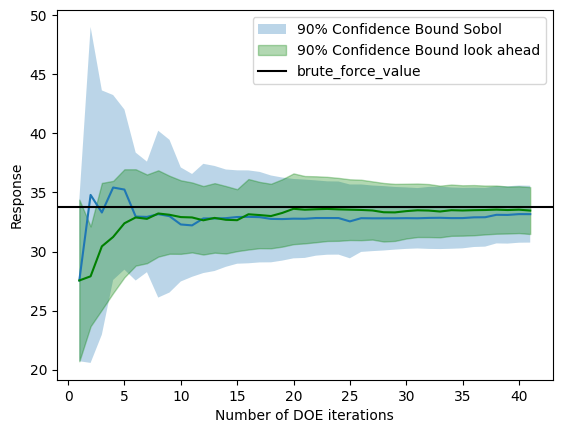

In [25]:
mean, var = get_mean_var(qoi_estimator, qoi_results_sobol)
ax = plot_raw_ut_estimates(mean, var, name="Sobol")
mean, var = get_mean_var(qoi_estimator, qoi_results_look_ahead)
ax = plot_raw_ut_estimates(mean, var, ax=ax, color="green", name="look ahead")
_ = ax.axhline(brute_force_qoi_estimate, c="black", label="brute_force_value")
_ = ax.set_xlabel("Number of DOE iterations")
_ = ax.set_ylabel("Response")
_ = ax.legend()